THIS IS A KAGGLE CHALLENGE: DOG BREED IDENTIFICATION - Link: https://www.kaggle.com/c/dog-breed-identification

In [81]:
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [13]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [14]:
LABELS_DIR = "data/labels.csv"
TRAINING_DIR = "data/train"
TEST_DIR = "data/test"

In [15]:
MAKE_DATA = 0    #Change to 1 to make up the data
PROCESS_DATA = 1 #Change to 1 when training
TRAIN_DATA = 0   #Change to 1 to train data again else load trained model

In [16]:
IMG_SIZE = 224
BATCH_SIZE = 64
TRAINING_SAMPLES = 8000
VAL_SAMPLES = 2222

In [17]:
#Read file and make folders

if MAKE_DATA:
    filelist = []
    with open(LABELS_DIR) as file:
        line = csv.reader(file)
        for row in line:
            filelist.append(row)

    for name,label in filelist[1:]:
        path = os.path.join(TRAINING_DIR,name+".jpg")
        out_path = os.path.join(TRAINING_DIR,label,name+".jpg")
        if not os.path.isdir(os.path.join(TRAINING_DIR,label)):
            os.mkdir(os.path.join(TRAINING_DIR,label))
        os.rename(path,out_path)

In [18]:
#Data Augmentation 
data_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((IMG_SIZE,IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [19]:
#Split data into Train set and Val set, then put into dataloader
if PROCESS_DATA:
    dataset = datasets.ImageFolder(TRAINING_DIR, transform=data_transform)
    trainset, valset = data.random_split(dataset, [TRAINING_SAMPLES, VAL_SAMPLES])
    trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
    valloader = data.DataLoader(valset, batch_size=BATCH_SIZE, num_workers=4)

In [20]:
LABELS = dataset.classes
NUM_CLASSES = len(LABELS)
print(NUM_CLASSES)

120


In [21]:
print(LABELS)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

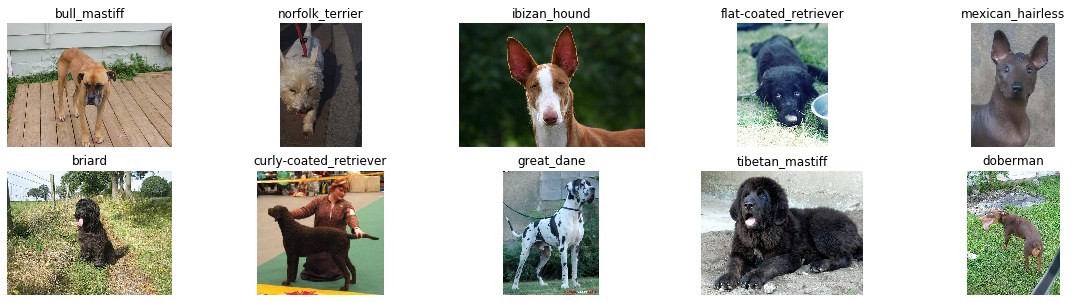

In [22]:
#Visualize some training samples:
NUM_PIC = 10
a = np.random.randint(0,NUM_CLASSES,NUM_PIC)
fig = plt.figure(figsize=(20,5))
for count, id in enumerate(a):
    label = LABELS[id]
    path = os.path.join(TRAINING_DIR,label)
    img_list = os.listdir(path)
    b = np.random.randint(0,len(img_list))
    img_path = img_list[b]
    fig.add_subplot(2,NUM_PIC/2,count+1)
    img = Image.open(os.path.join(path,img_path))
    plt.imshow(img)
    plt.axis("off")
    plt.title(label)
plt.show()
    

In [23]:
#Training step
def training_step(model, optimizer, error, trainloader):
    train_loss = 0
    model.train()
    for id, (img, label) in enumerate(trainloader):
        model.zero_grad()
        img = Variable(img).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
        label = Variable(label).to(device)
        outputs = model(img)
        loss = error(outputs, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.data
    return train_loss

In [24]:
#Validation step
def evaluating_step(model, optimizer, error, valloader):
    val_loss = 0
    total = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for (img, label) in valloader:
            img = Variable(img).view(-1,3,IMG_SIZE,IMG_SIZE).to(device)
            label = Variable(label).to(device)
            outputs = model(img)
            prediction = torch.max(outputs.data, 1)[1]
            loss = error(outputs, label)
            total += len(img)
            correct += (label == prediction).sum()
            val_loss += loss.data
        accuracy = correct*1.0/total
    return val_loss, accuracy

In [25]:
#Train process
def train(model, optimizer, error, trainloader, valloader):
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []
    EPOCHS = 20
    print("Start training...")
    for epoch in range(EPOCHS):
        train_loss = training_step(model, optimizer, error, trainloader)
        val_loss, val_acc = evaluating_step(model, optimizer, error, valloader)
        
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        print("Epoch: ({}/{}), Train Loss: {:4f}, Val Loss: {:4f}, Val Acc: {:4f}".format(epoch+1,EPOCHS, train_loss, val_loss, val_acc))
    print("Training Completed! Saving model...")
    torch.save(model.state_dict(), "model/model2.pth")
    print("Model saved!")
    return model, train_loss_list, val_loss_list, val_acc_list

In [26]:
#Plot loss curve
def plot(train_loss_list, val_loss_list, val_acc_list, EPOCH):
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1,2,1)
    plt.plot(range(EPOCH),train_loss_list, label = "Training Loss")
    plt.plot(range(EPOCH),val_loss_list, color = "orange", label = "Validation Loss")
    plt.legend()
    plt.title("Loss per epoch")
    fig.add_subplot(1,2,2)
    plt.plot(range(EPOCH),val_acc_list)
    plt.title("Validation Accuracy")
    plt.show()

In [206]:
    model = models.resnet50(pretrained=True)
    model = model.to(device)
    
    #Freeze all convolution layer
    for param in model.parameters():
            param.requires_grad = False
            
    #Unfreeze Fully-connected layer, edit the last layer 
    model.fc = nn.Linear(in_features=2048, out_features=NUM_CLASSES).to(device)
    
if TRAIN_DATA:
    error = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0002)
    model, train_loss_list, val_loss_list, val_acc_list = train(model,optimizer,error,trainloader,valloader)
    

Start training...
Epoch: (1/20), Train Loss: 461.891266, Val Loss: 92.711952, Val Acc: 0.653015
Epoch: (2/20), Train Loss: 257.290405, Val Loss: 55.917061, Val Acc: 0.768677
Epoch: (3/20), Train Loss: 167.342682, Val Loss: 41.325630, Val Acc: 0.790279
Epoch: (4/20), Train Loss: 125.882599, Val Loss: 33.643539, Val Acc: 0.824482
Epoch: (5/20), Train Loss: 103.495354, Val Loss: 29.178219, Val Acc: 0.821332
Epoch: (6/20), Train Loss: 89.512726, Val Loss: 26.774841, Val Acc: 0.837984
Epoch: (7/20), Train Loss: 79.905434, Val Loss: 24.792021, Val Acc: 0.832583
Epoch: (8/20), Train Loss: 72.065590, Val Loss: 23.777596, Val Acc: 0.829883
Epoch: (9/20), Train Loss: 66.397614, Val Loss: 23.197990, Val Acc: 0.837534
Epoch: (10/20), Train Loss: 61.874325, Val Loss: 22.307014, Val Acc: 0.835284
Epoch: (11/20), Train Loss: 57.182087, Val Loss: 21.460356, Val Acc: 0.837084
Epoch: (12/20), Train Loss: 53.974178, Val Loss: 21.043375, Val Acc: 0.840234
Epoch: (13/20), Train Loss: 51.362717, Val Loss: 2

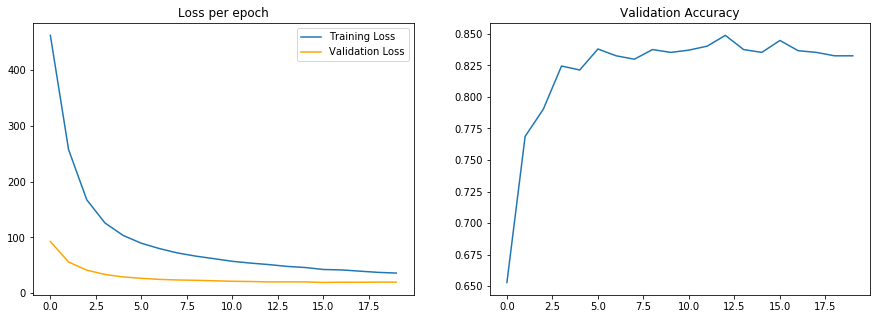

In [207]:
#Plot learning curves
plot(train_loss_list,val_loss_list,val_acc_list,len(train_loss_list))

In [28]:
#Load trained model
if not TRAIN_DATA:
    model = models.resnet50(pretrained=True)
    model = model.to(device)
    
    #Freeze all convolution layer
    for param in model.parameters():
            param.requires_grad = False
            
    #Unfreeze Fully-connected layer, edit the last layer 
    model.fc = nn.Linear(in_features=2048, out_features=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load("model/model2.pth"))

In [32]:
test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [82]:
#Predict input images
def predict(model, images):
    model.eval()
    with torch.no_grad():
        test = Variable(images).view(-1,3,IMG_SIZE,IMG_SIZE)
        test = test.to(device)
        outputs = model(test)
        prediction = outputs.data
        prediction = F.softmax(prediction,dim=1)
        #prediction = torch.max(outputs.data, 1)[1]
    return prediction.cpu().numpy()[0]

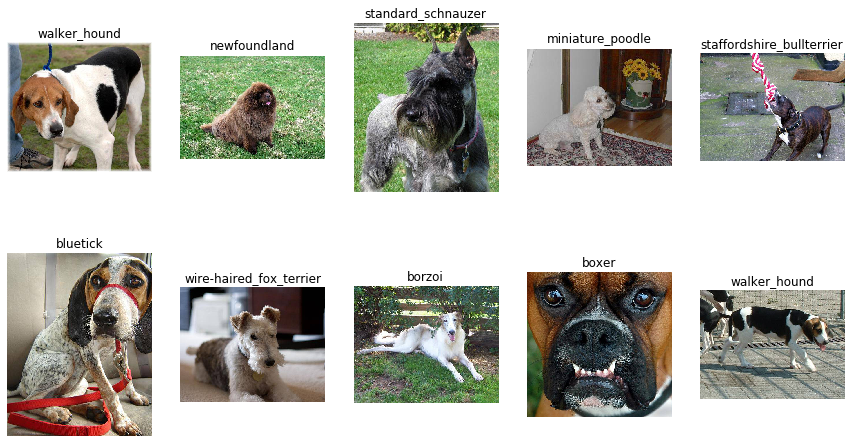

In [96]:
#Visualize test data
def visualize_model(model,TEST_DIR, NUM_PIC = 10):
    test_path = os.listdir(TEST_DIR)
    a = np.random.randint(10000)
    fig = plt.figure(figsize=(15,8))
    for id, i in enumerate(test_path[a:a+NUM_PIC]):
        img = Image.open(os.path.join(TEST_DIR,i))
        img2 = test_transform(img)
        result = predict(model,img2)
        result = np.argmax(result)
        fig.add_subplot(2,NUM_PIC/2,id+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(LABELS[result])
    plt.show()
visualize_model(model,TEST_DIR,10)

In [93]:
from tqdm import tqdm

In [94]:
#Make csv file for submission 
def make_submission(model):
    lines = []
    test_path = os.listdir(TEST_DIR)
    for id, i in tqdm(enumerate(test_path[:])):
        img = Image.open(os.path.join(TEST_DIR,i))
        img2 = test_transform(img)
        result = list(predict(model,img2))
        lines.append([i[:-4], result])
    
    with open("submission.csv", "w", newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["id"] + LABELS)
        for i in lines:
            writer.writerow([i[0]]+ ['{:20f}'.format(j) for j in i[1]])
    
make_submission(model)

10357it [04:57, 34.76it/s]
